# 📈 Evaluación Exhaustiva del Modelo (Model Evaluation)

## 🎯 Objetivo
Este notebook tiene como objetivo evaluar el rendimiento del modelo final (`best_pipeline.pkl`) en un conjunto de datos de prueba o validación. 
El enfoque principal está en métricas críticas para el diagnóstico médico, como el **Recall** (Sensibilidad) y el **F2-Score**, además de la interpretabilidad del modelo.

## 📋 Agenda
1.  **Configuración**: Importación de librerías y definición de rutas.
2.  **Carga de Artefactos**: Modelo, datos y configuración.
3.  **Predicciones**: Generación de probabilidades en el set de prueba.
4.  **Métricas Clave**: Matriz de Confusión, Reporte de Clasificación, ROC-AUC.
5.  **Visualización**: Curvas ROC, Precision-Recall y Feature Importance.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import shap

from pycaret.classification import load_model, predict_model
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    auc, 
    fbeta_score
)

# Configuración de Estilo Visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Rutas de Archivos
MODEL_PATH = "../models/best_pipeline"
DATA_PATH = "../data/02_intermediate/process_data.parquet"
THRESHOLD_CONFIG_PATH = "../models/threshold_config.json"
CONFIG_PATH = "../models/model_config.json"

## 1. Carga de Datos y Modelo

In [96]:
# 1.1 Cargar Modelo
try:
    pipeline = load_model(MODEL_PATH)
    print("✅ Modelo cargado exitosamente.")
except Exception as e:
    print(f"❌ Error al cargar el modelo: {e}")

# 1.2 Cargar Datos
try:
    df = pd.read_parquet(DATA_PATH)
    # Usamos una muestra del 20% para simular un set de prueba si no está predefinido
    # En un escenario real de producción, cargarías tu 'test_data.parquet' específico
    df_eval = df.sample(frac=0.2, random_state=42)
    print(f"✅ Datos cargados. Shape evaluación: {df_eval.shape}")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")

# 1.3 Cargar Configuración de Umbral (Automático)
OPTIMAL_THRESHOLD = 0.37
if os.path.exists(THRESHOLD_CONFIG_PATH):
    try:
        with open(THRESHOLD_CONFIG_PATH, 'r') as f:
            thresh_config = json.load(f)
            OPTIMAL_THRESHOLD = thresh_config.get('optimal_threshold', 0.5)
        print(f"✅ Umbral archivo cargado: {OPTIMAL_THRESHOLD:.4f}")
    except:
        print("⚠️ Error leyendo threshold_config.json")
else:
    print("⚠️ No se encontró threshold_config.json. Usando 0.5.")

# 1.4 Configuración Manual del Umbral (Sobrescribir)
# =============================================================================
# 🔧 CONFIGURA AQUÍ TU UMBRAL SI DESEAS CAMBIARLO
# =============================================================================
MANUAL_THRESHOLD = 0.44  # <--- ¡MODIFICA ESTE VALOR!

if MANUAL_THRESHOLD is not None:
    OPTIMAL_THRESHOLD = MANUAL_THRESHOLD
    print(f"🔹 Usando umbral MANUAL para evaluación: {OPTIMAL_THRESHOLD}")
else:
    print(f"🔹 Usando umbral AUTOMÁTICO para evaluación: {OPTIMAL_THRESHOLD}")


# 1.5 Cargar Target Column Name
TARGET_COL = 'HeartDisease' # Default
if os.path.exists(CONFIG_PATH):
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)
        TARGET_COL = config.get('target', 'HeartDisease')

Transformation Pipeline and Model Successfully Loaded
✅ Modelo cargado exitosamente.
✅ Datos cargados. Shape evaluación: (8739, 29)
✅ Umbral archivo cargado: 0.0000
🔹 Usando umbral MANUAL para evaluación: 0.44


## 2. Generación de Predicciones

In [91]:
# Generar predicciones (probabilidades crudas)
predictions = predict_model(pipeline, data=df_eval, raw_score=True)

# Identificar columna de probabilidad de clase positiva (1)
score_col = 'prediction_score_1' if 'prediction_score_1' in predictions.columns else 'prediction_score'

# Normalizar scores si es necesario
if score_col == 'prediction_score':
    # Si label es 1, score es prob(1). Si label es 0, score es prob(0) -> prob(1) = 1 - score
    y_prob = predictions.apply(lambda x: x['prediction_score'] if x['prediction_label'] == 1 else 1 - x['prediction_score'], axis=1)
else:
    y_prob = predictions[score_col]

# Obtener etiquetas reales
y_true = predictions[TARGET_COL]

# Aplicar Umbral Definido
y_pred_custom = (y_prob >= OPTIMAL_THRESHOLD).astype(int)

print(f"Predicciones generadas. Umbral aplicado: {OPTIMAL_THRESHOLD}")

Predicciones generadas. Umbral aplicado: 0.44


## 3. Evaluación de Desempeño

       RESUMEN DE MÉTRICAS (TEST)       
⭐ F2-Score (Beta=2): 0.3578
⭐ ROC AUC Score:     0.9021
----------------------------------------

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      8522
         1.0       0.14      0.57      0.23       217

    accuracy                           0.91      8739
   macro avg       0.57      0.74      0.59      8739
weighted avg       0.97      0.91      0.93      8739



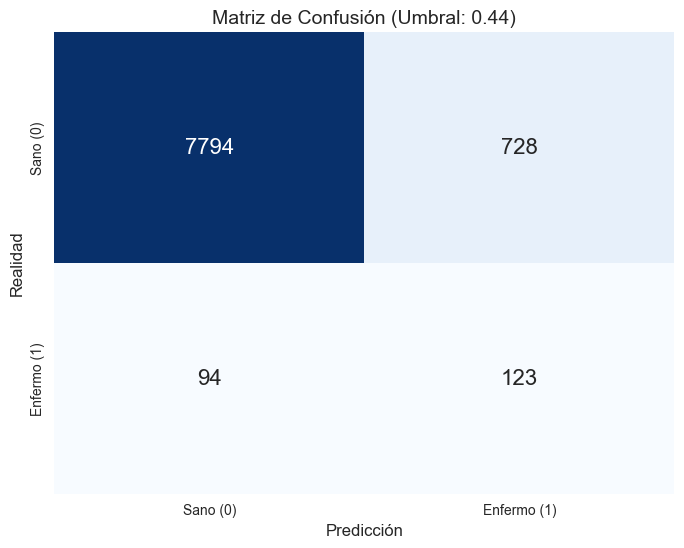

In [92]:
# Calcular métricas clave
f2 = fbeta_score(y_true, y_pred_custom, beta=2)
roc_auc = roc_auc_score(y_true, y_prob)

print("="*40)
print("       RESUMEN DE MÉTRICAS (TEST)       ")
print("="*40)
print(f"⭐ F2-Score (Beta=2): {f2:.4f}")
print(f"⭐ ROC AUC Score:     {roc_auc:.4f}")
print("-"*40)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred_custom))

# Visualizar Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sano (0)', 'Enfermo (1)'],
            yticklabels=['Sano (0)', 'Enfermo (1)'],
            annot_kws={"size": 16})
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Realidad', fontsize=12)
plt.title(f'Matriz de Confusión (Umbral: {OPTIMAL_THRESHOLD:.2f})', fontsize=14)
plt.show()

## 4. Curvas de Rendimiento (ROC & PR)
Estas curvas nos ayudan a entender cómo se comporta el modelo a través de diferentes umbrales de decisión.

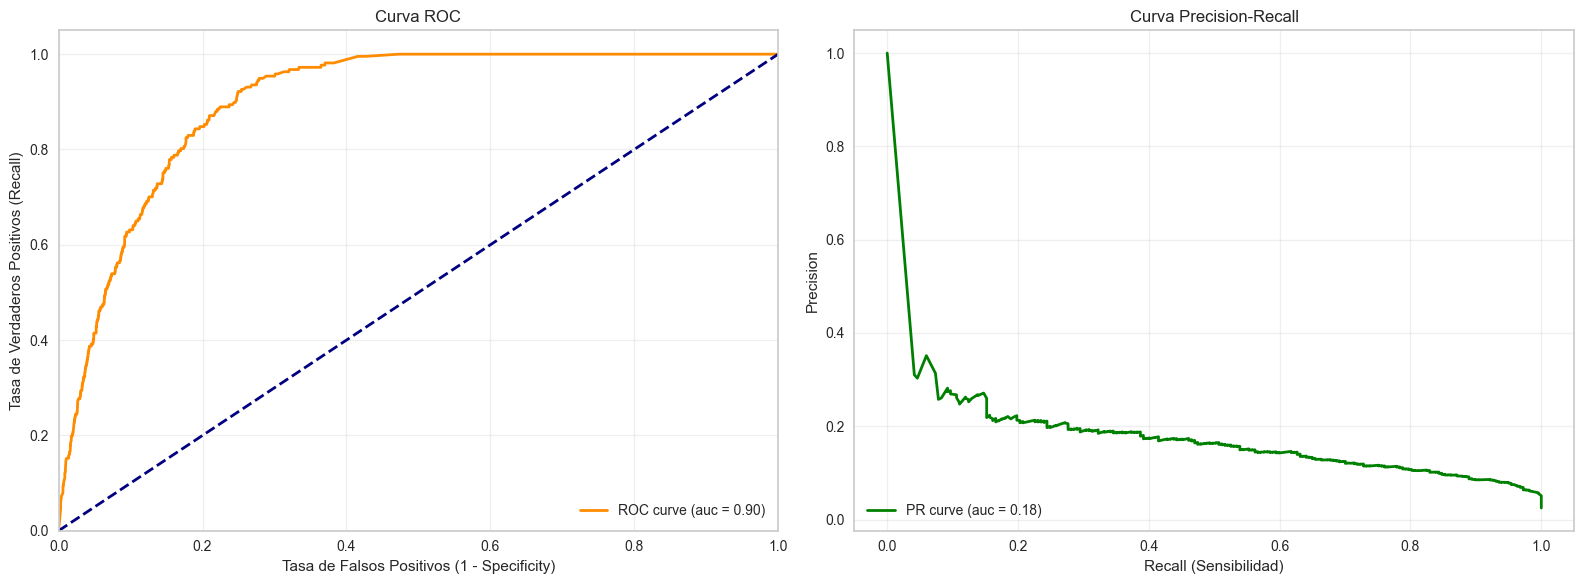

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 4.1 Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (auc = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de Falsos Positivos (1 - Specificity)')
ax1.set_ylabel('Tasa de Verdaderos Positivos (Recall)')
ax1.set_title('Curva ROC')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 4.2 Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)
ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (auc = {pr_auc:.2f})')
ax2.set_xlabel('Recall (Sensibilidad)')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Importancia de Variables (Pesos del Modelo)

A diferencia de SHAP (que explica el impacto en la salida), este gráfico muestra qué variables usa más internamente el modelo (ej. ganancia en árboles).

📊 Generando gráfico de pesos de variables...


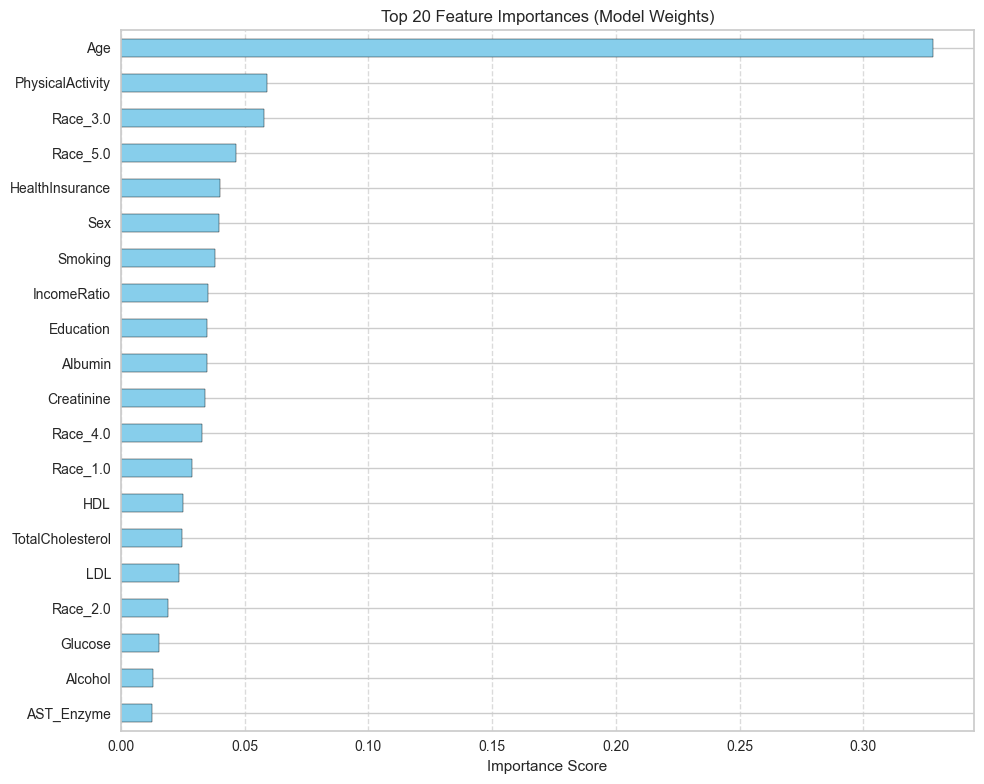

In [94]:
# Extraer y visualizar Feature Importances del modelo cargado
try:
    print("📊 Generando gráfico de pesos de variables...")
    
    # 1. Obtener el estimador final del pipeline
    # pipeline variable should affect loaded from previous celss
    if 'pipeline' in locals():
        model_step = pipeline.steps[-1][1]
        final_model = get_base_estimator(model_step)

        # 2. Intentar obtener importancias
        if hasattr(final_model, 'feature_importances_'):
            importances = final_model.feature_importances_
            
            # 3. Intentar obtener nombres de features
            feature_names = []
            if hasattr(final_model, 'feature_names_in_'):
                feature_names = final_model.feature_names_in_
            elif hasattr(pipeline[:-1], 'get_feature_names_out'): # Sklearn pipelines
                 try:
                     feature_names = pipeline[:-1].get_feature_names_out()
                 except:
                     pass
            
            # 4. Crear DataFrame para plotear
            if len(feature_names) == len(importances):
                s_imp = pd.Series(importances, index=feature_names)
            else:
                # Si no coinciden o no hay nombres, usar indices genéricos
                s_imp = pd.Series(importances, index=[f'Feature {i}' for i in range(len(importances))])
            
            # 5. Plotear Top 20
            plt.figure(figsize=(10, 8))
            s_imp.nlargest(20).sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
            plt.title("Top 20 Feature Importances (Model Weights)")
            plt.xlabel("Importance Score")
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ El modelo final no expone el atributo 'feature_importances_'.")
    else:
        print("⚠️ Validar que la variable 'pipeline' esté cargada correctamente.")
        
except Exception as e:
    print(f"❌ Error generando el gráfico de importancia: {e}")

## 7. Optimización de Umbral (Threshold Optimization)

Evaluamos cómo cambian las métricas (Precision, Recall, F1, F2) al variar el umbral de decisión. Esto es crucial para ajustar la sensibilidad del modelo.

📈 Calculando métricas para múltiples umbrales...
🎯 Mejor Umbral (Max F2-Score): 0.40 (F2: 0.3747)


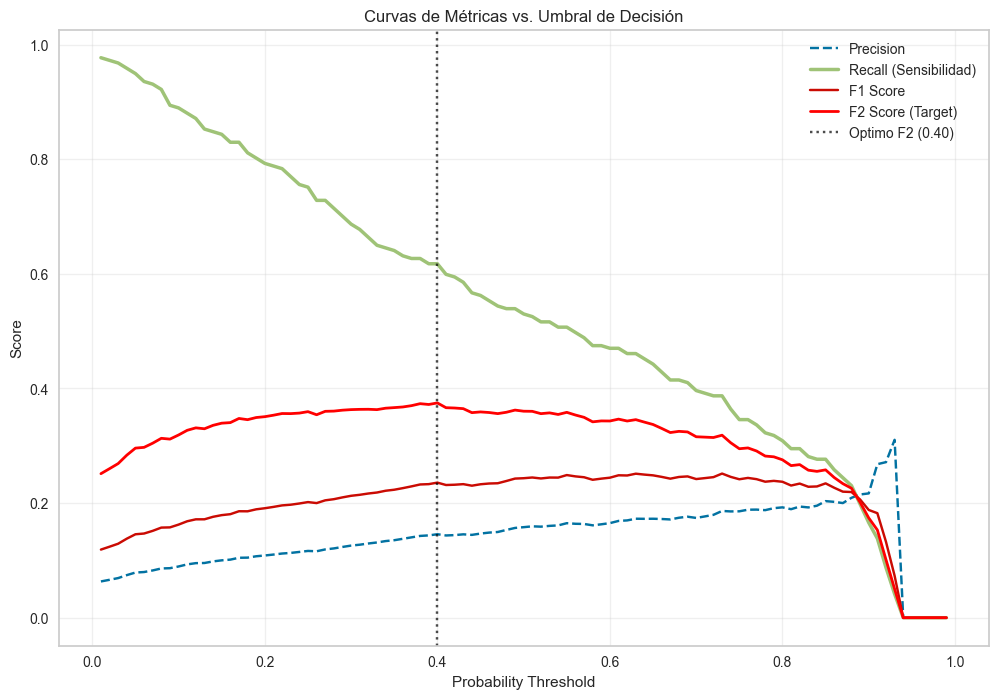

In [95]:
# Análisis de Sensibilidad al Umbral
try:
    print("📈 Calculando métricas para múltiples umbrales...")
    
    thresholds = np.arange(0.01, 1.00, 0.01)
    
    # Listas para almacenar métricas
    recalls = []
    precisions = []
    f1_scores = []
    f2_scores = []
    
    # Usamos y_true y y_prob calculados previamente
    # Asegurar que y_true sea int
    y_true_int = y_true.astype(int)
    
    for thresh in thresholds:
        # Predicciones binarias para este umbral
        y_pred_th = (y_prob >= thresh).astype(int)
        
        # Calcular métricas (usando zero_division=0 para evitar warnings en extremos)
        # Nota: classification_report devuelve dict
        report = classification_report(y_true_int, y_pred_th, output_dict=True, zero_division=0)
        # Clase positiva es '1'
        # Si '1' no está en report (ej. todos 0), manejarlo
        if '1' in report:
             p = report['1']['precision']
             r = report['1']['recall']
             f1 = report['1']['f1-score']
        elif '1.0' in report:
             p = report['1.0']['precision']
             r = report['1.0']['recall']
             f1 = report['1.0']['f1-score']
        else:
             p, r, f1 = 0.0, 0.0, 0.0
             
        f2 = fbeta_score(y_true_int, y_pred_th, beta=2, zero_division=0)
        
        precisions.append(p)
        recalls.append(r)
        f1_scores.append(f1)
        f2_scores.append(f2)
        
    # Crear DataFrame
    metrics_df = pd.DataFrame({
        'Threshold': thresholds,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'F2-Score': f2_scores
    })
    
    # Encontrar el mejor umbral para F2 (prioridad en salud)
    best_f2_idx = metrics_df['F2-Score'].idxmax()
    best_f2_thresh = metrics_df.loc[best_f2_idx, 'Threshold']
    best_f2_val = metrics_df.loc[best_f2_idx, 'F2-Score']
    
    print(f"🎯 Mejor Umbral (Max F2-Score): {best_f2_thresh:.2f} (F2: {best_f2_val:.4f})")

    # Graficar curvas
    plt.figure(figsize=(12, 8))
    plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision', linestyle='--')
    plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall (Sensibilidad)', linewidth=2.5)
    plt.plot(metrics_df['Threshold'], metrics_df['F1-Score'], label='F1 Score')
    plt.plot(metrics_df['Threshold'], metrics_df['F2-Score'], label='F2 Score (Target)', color='red', linewidth=2)
    
    # Línea vertical del óptimo
    plt.axvline(best_f2_thresh, color='black', linestyle=':', alpha=0.7, label=f'Optimo F2 ({best_f2_thresh:.2f})')
    
    plt.title("Curvas de Métricas vs. Umbral de Decisión")
    plt.xlabel("Probability Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"❌ Error en análisis de umbrales: {e}")